# Single DK rumour spreading model


In [124]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from enum import Enum

class State(Enum):
    SPREADER = 0 # People actively spreading the rumour
    IGNORANT = 1 # People who haven't encountered the rumour
    STIFLER = 2 # People who have heard the rumour but are not spreading it

TIME_STEPS = 25
POPULATION_SIZE = 4039
CLIQUISHNESS = 44

ACTIVENESS = 0.1
RUMOUR_ACCEPTANCE_PROB = 0.2
SPREADER_SPREADER_STIFLE_PROB = 0.1
SPREADER_STIFLER_STIFLE_PROB = 0.1
FORGET_PROB = 0.01

In [125]:
class Person:
    def __init__(self) -> None:
        self.state = State.IGNORANT
        self.contacted = []

    def spread_rumour(self, neighbour):
        # Checks the nodes are active and haven't already contacted each other
        if neighbour in self.contacted:
            return
        if np.random.random() > ACTIVENESS:
            return

        # Add each other to the contacted list so they don't contact each other again this time step
        self.contacted.append(neighbour)
        neighbour.contacted.append(self)

        # If neighbour is ignorant
        if neighbour.state == State.IGNORANT:
            if np.random.random() < RUMOUR_ACCEPTANCE_PROB:
                neighbour.state = State.SPREADER
        # If neighbour is a spreader
        elif neighbour.state == State.SPREADER:
            if np.random.random() < SPREADER_SPREADER_STIFLE_PROB:
                neighbour.state = State.STIFLER
            if np.random.random() < SPREADER_SPREADER_STIFLE_PROB:
                self.state = State.STIFLER
        # If neighbour is a stifler
        elif neighbour.state == State.STIFLER:
            if np.random.random() < SPREADER_STIFLER_STIFLE_PROB:
                self.state = State.STIFLER

    def next(self):
        if np.random.random() < FORGET_PROB:
            self.state = State.IGNORANT

        self.contacted = []

    def set_state(self, state):
        self.state = state



In [140]:
class DKModel:
    def __init__(self, graph, initial_rumour_spreaders: int) -> None:
        self.graph = graph

        for node in range(POPULATION_SIZE):
            graph.nodes[node]['agent'] = Person()

        rumour_starters = np.random.choice(graph.nodes, initial_rumour_spreaders, replace=False)
        for node in rumour_starters:
            graph.nodes[node]['agent'].set_state(State.SPREADER)

        # History tracking
        self.s_history = []
        self.i_history = []
        self.r_history = []

    def step(self) -> None:
        for node in self.graph.nodes:
            agent = self.graph.nodes[node]['agent']

            for neighbour in self.graph.neighbors(node):
                if not agent.state == State.SPREADER:
                    break
                agent.spread_rumour(self.graph.nodes[neighbour]['agent'])

        # Count states
        spreaders, ignorants, stiflers = self.count_states()

        self.s_history.append(spreaders)
        self.i_history.append(ignorants)
        self.r_history.append(stiflers)

        for node in self.graph.nodes:
            agent = self.graph.nodes[node]['agent']
            agent.next()

    def count_states(self):
        spreaders, ignorants, stiflers = 0, 0, 0
        for node in self.graph.nodes:
            agent = self.graph.nodes[node]['agent']
            if agent.state == State.SPREADER:
                spreaders += 1
            elif agent.state == State.IGNORANT:
                ignorants += 1
            elif agent.state == State.STIFLER:
                stiflers += 1
        return spreaders, ignorants, stiflers

    def draw(self) -> None:
        plt.figure(figsize=(10, 6))

        # Assemble colour map
        colours = []
        for node in self.graph.nodes:
            agent = self.graph.nodes[node]['agent']
            if agent.state == State.SPREADER:
                colours.append('red')
            elif agent.state == State.IGNORANT:
                colours.append('blue')
            elif agent.state == State.STIFLER:
                colours.append('green')

        nx.draw(self.graph, node_size=50, node_color=colours, with_labels=False)
        plt.title('DK Model of Rumor Propagation on a Graph')
        plt.show()

    def run(self, time_steps: int, draw=False) -> None:
        for _ in range(time_steps):
            if draw:
                self.draw()
            self.step()
        if draw:
            self.draw()

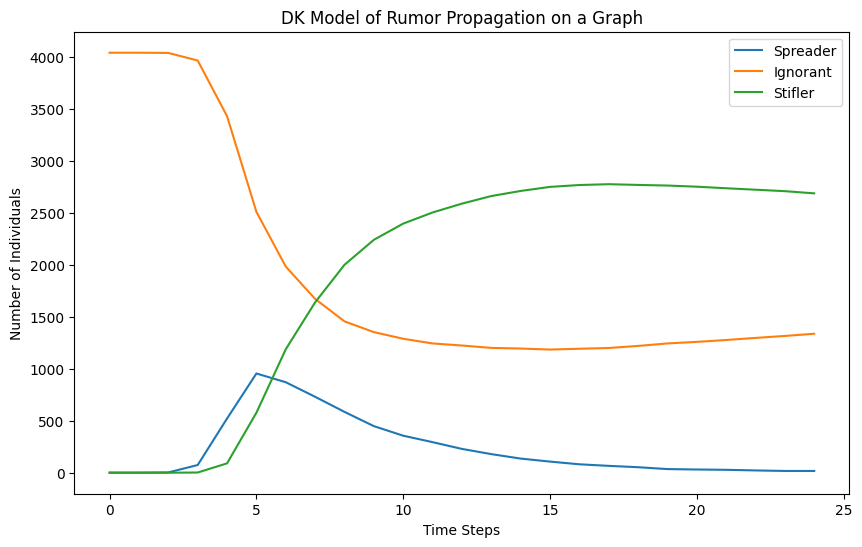

In [142]:
graph = nx.barabasi_albert_graph(POPULATION_SIZE, CLIQUISHNESS)
dk_model = DKModel(graph, initial_rumour_spreaders=1)
dk_model.run(TIME_STEPS, draw=False)

plt.figure(figsize=(10, 6))
plt.plot(dk_model.s_history, label='Spreader')
plt.plot(dk_model.i_history, label='Ignorant')
plt.plot(dk_model.r_history, label='Stifler')
plt.title('DK Model of Rumor Propagation on a Graph')
plt.xlabel('Time Steps')
plt.ylabel('Number of Individuals')
plt.legend()
plt.show()

